In [3]:
import pandas as pd
import duckdb as db
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Connected to database: ../../database/clinisys_all.duckdb
Database file exists: True

=== Available Schemas ===
          schema_name
0              bronze
1                gold
2                main
3              silver
4  information_schema
5                main
6          pg_catalog
7                main

=== Tables in Silver Schema (16 tables) ===
                           table_name  table_type
0         view_congelamentos_embrioes  BASE TABLE
1           view_congelamentos_ovulos  BASE TABLE
2      view_descongelamentos_embrioes  BASE TABLE
3        view_descongelamentos_ovulos  BASE TABLE
4            view_embrioes_congelados  BASE TABLE
5   view_extrato_atendimentos_central  BASE TABLE
6                   view_medicamentos  BASE TABLE
7       view_medicamentos_prescricoes  BASE TABLE
8                        view_medicos  BASE TABLE
9               view_micromanipulacao  BASE TABLE
10      view_micromanipulacao_oocitos  BASE TABLE
11                    view_orcamentos  BASE T
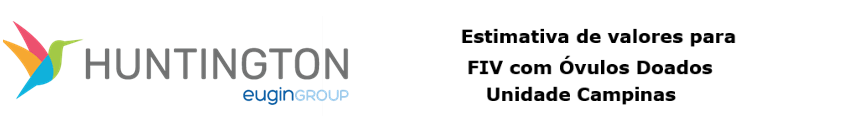
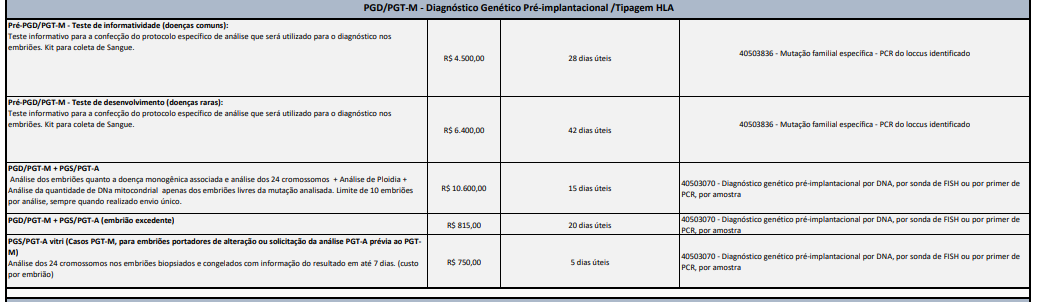
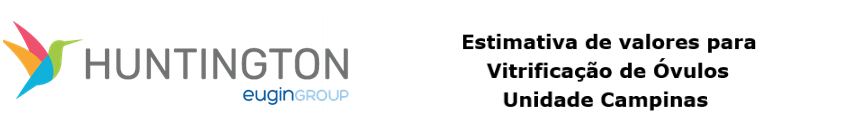
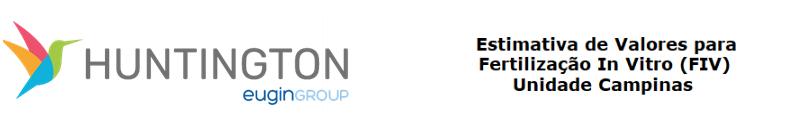
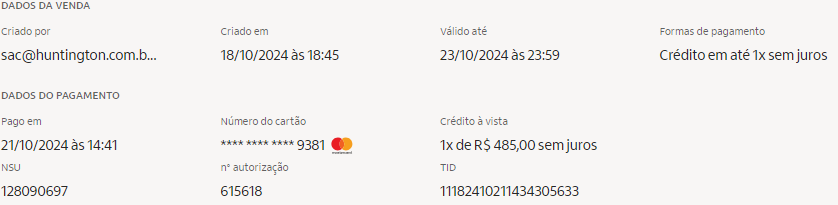
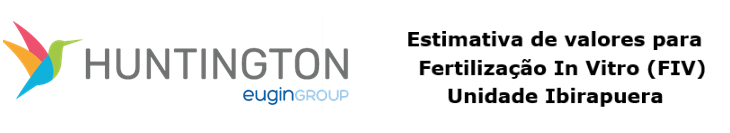
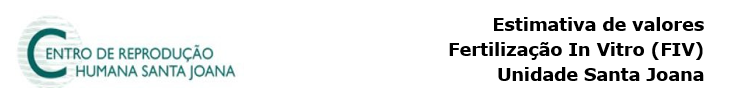
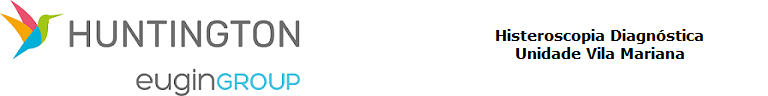

In [4]:
# Connect to the clinisys_all database
path_to_db = '../../database/clinisys_all.duckdb'

print(f"Connected to database: {path_to_db}")
print(f"Database file exists: {os.path.exists(path_to_db)}")

# Use context manager for automatic connection cleanup
with db.connect(path_to_db, read_only=True) as conn:
    # List all schemas
    schemas = conn.execute("SELECT schema_name FROM information_schema.schemata").fetchdf()
    print("\n=== Available Schemas ===")
    print(schemas)

    # List all tables in silver schema
    silver_tables = conn.execute("""
        SELECT table_name, table_type 
        FROM information_schema.tables 
        WHERE table_schema = 'silver'
        ORDER BY table_name
    """).fetchdf()

    print(f"\n=== Tables in Silver Schema ({len(silver_tables)} tables) ===")
    print(silver_tables)

    # Explore each table in silver schema
    print("\n" + "="*80)
    print("EXPLORING SILVER SCHEMA TABLES")
    print("="*80)

    for idx, row in silver_tables.iterrows():
        table_name = row['table_name']
        table_type = row['table_type']
        
        print(f"\n{'='*60}")
        print(f"TABLE: {table_name} (Type: {table_type})")
        print(f"{'='*60}")
        
        try:
            # Get table schema
            schema_info = conn.execute(f"""
                SELECT column_name, data_type, is_nullable
                FROM information_schema.columns 
                WHERE table_schema = 'silver' AND table_name = '{table_name}'
                ORDER BY ordinal_position
            """).fetchdf()
            
            print(f"\nSchema ({len(schema_info)} columns):")
            # print(schema_info.to_string(index=False))
            
            # Get row count
            count_result = conn.execute(f"SELECT COUNT(*) as row_count FROM silver.{table_name}").fetchdf()
            row_count = count_result['row_count'].iloc[0]
            print(f"\nTotal rows: {row_count:,}")
            
            # Get sample data (first 10 rows)
            if row_count > 0:
                sample_data = conn.execute(f"SELECT * FROM silver.{table_name} LIMIT 10").fetchdf()
                print(f"\nSample data (first 10 rows):")
                print(sample_data.to_string(index=False))
                
                # Show data types and null counts
                print(f"\nData info:")
                print(f"Shape: {sample_data.shape}")
                print(f"Memory usage: {sample_data.memory_usage(deep=True).sum() / 1024:.2f} KB")
                
                # Show null counts for each column
                null_counts = sample_data.isnull().sum()
                if null_counts.sum() > 0:
                    print(f"\nNull counts in sample:")
                    for col, null_count in null_counts.items():
                        if null_count > 0:
                            print(f"  {col}: {null_count}")
            else:
                print("\nTable is empty - no sample data to show")
                
        except Exception as e:
            print(f"Error exploring table {table_name}: {str(e)}")
        
        print(f"\n{'-'*60}")

print(f"\n{'='*80}")
print("EXPLORATION COMPLETE")
print(f"{'='*80}")

In [5]:
#!/usr/bin/env python3
"""
Extract Prontuario Data - Modular Functions
Extract data for a specific prontuario from finops tables with individual functions for each table.
"""

import pandas as pd
import duckdb as db
import os

def get_database_connection():
    """
    Create and return a connection to the clinisys_all database
    
    Returns:
        duckdb.DuckDBPyConnection: Database connection
    """
    path_to_db = '../../database/clinisys_all.duckdb'
    conn = db.connect(path_to_db, read_only=True)
    
    print(f"Connected to database: {path_to_db}")
    print(f"Database file exists: {os.path.exists(path_to_db)}")
    
    return conn

def get_database_context():
    """
    Create a context manager for the clinisys_all database connection
    
    Returns:
        context manager: Database connection context manager
    """
    path_to_db = '../../database/clinisys_all.duckdb'
    return db.connect(path_to_db, read_only=True)

def extract_orcamentos_data(conn, target_prontuario):
    """
    Extract orcamentos data for a specific prontuario
    
    Args:
        conn: Database connection
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        pd.DataFrame: DataFrame containing orcamentos data
    """
    print(f"\n2. EXTRACTING VIEW_ORCAMENTOS DATA")
    print("-" * 50)
    
    try:
        # Check schema first
        schema_orc = conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = 'view_orcamentos'
            ORDER BY ordinal_position
        """).fetchdf()
        print(f"view_orcamentos columns: {list(schema_orc['column_name'])}")
        
        # Extract data
        orcamentos_df = conn.execute(f"""
            SELECT * FROM silver.view_orcamentos 
            WHERE prontuario = {target_prontuario}
            ORDER BY id DESC
        """).fetchdf()
        
        print(f"Found {len(orcamentos_df)} records in view_orcamentos")
        if len(orcamentos_df) > 0:
            print("Sample data:")
            print(orcamentos_df.head())
            print(f"Columns: {list(orcamentos_df.columns)}")
        else:
            print("No data found for this prontuario")
            
    except Exception as e:
        print(f"Error extracting orcamentos data: {str(e)}")
        orcamentos_df = pd.DataFrame()
    
    return orcamentos_df

def extract_extrato_atendimento_central_data(conn, target_prontuario):
    """
    Extract extrato_atendimento_central data for a specific prontuario
    
    Args:
        conn: Database connection
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        pd.DataFrame: DataFrame containing extrato_atendimento_central data
    """
    print(f"\n3. EXTRACTING VIEW_EXTRATO_ATENDIMENTO_CENTRAL DATA")
    print("-" * 50)
    
    try:
        # Check schema first
        schema_eac = conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = 'view_extrato_atendimentos_central'
            ORDER BY ordinal_position
        """).fetchdf()
        print(f"view_extrato_atendimento_central columns: {list(schema_eac['column_name'])}")
        
        # Extract data
        extrato_atendimento_central_df = conn.execute(f"""
            SELECT * FROM silver.view_extrato_atendimentos_central 
            WHERE prontuario = {target_prontuario}
            ORDER BY data DESC, inicio DESC
        """).fetchdf()
        
        print(f"Found {len(extrato_atendimento_central_df)} records in view_extrato_atendimento_central")
        if len(extrato_atendimento_central_df) > 0:
            print("Sample data:")
            print(extrato_atendimento_central_df.head())
            print(f"Columns: {list(extrato_atendimento_central_df.columns)}")
        else:
            print("No data found for this prontuario")
            
    except Exception as e:
        print(f"Error extracting extrato_atendimento_central data: {str(e)}")
        extrato_atendimento_central_df = pd.DataFrame()
    
    return extrato_atendimento_central_df

def extract_tratamentos_data(conn, target_prontuario):
    """
    Extract tratamentos data for a specific prontuario
    
    Args:
        conn: Database connection
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        pd.DataFrame: DataFrame containing tratamentos data
    """
    print(f"\n4. EXTRACTING VIEW_TRATAMENTOS DATA")
    print("-" * 50)
    
    try:
        # Check schema first
        schema_trat = conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = 'view_tratamentos'
            ORDER BY ordinal_position
        """).fetchdf()
        print(f"view_tratamentos columns: {list(schema_trat['column_name'])}")
        
        # Extract data
        tratamentos_df = conn.execute(f"""
            SELECT * FROM silver.view_tratamentos 
            WHERE prontuario = {target_prontuario}
            ORDER BY id DESC
        """).fetchdf()
        
        print(f"Found {len(tratamentos_df)} records in view_tratamentos")
        if len(tratamentos_df) > 0:
            print("Sample data:")
            print(tratamentos_df.head())
            print(f"Columns: {list(tratamentos_df.columns)}")
        else:
            print("No data found for this prontuario")
            
    except Exception as e:
        print(f"Error extracting tratamentos data: {str(e)}")
        tratamentos_df = pd.DataFrame()
    
    return tratamentos_df

def extract_congelamentos_embrioes_data(conn, target_prontuario):
    """
    Extract congelamentos_embrioes data for a specific prontuario
    
    Args:
        conn: Database connection
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        pd.DataFrame: DataFrame containing congelamentos_embrioes data
    """
    print(f"\n5. EXTRACTING VIEW_CONGELAMENTOS_EMBRIOES DATA")
    print("-" * 50)
    
    try:
        # Check schema first
        schema_ce = conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = 'view_congelamentos_embrioes'
            ORDER BY ordinal_position
        """).fetchdf()
        print(f"view_congelamentos_embrioes columns: {list(schema_ce['column_name'])}")
        
        # Extract data
        congelamentos_embrioes_df = conn.execute(f"""
            SELECT * FROM silver.view_congelamentos_embrioes 
            WHERE prontuario = {target_prontuario}
            ORDER BY id DESC
        """).fetchdf()
        
        print(f"Found {len(congelamentos_embrioes_df)} records in view_congelamentos_embrioes")
        if len(congelamentos_embrioes_df) > 0:
            print("Sample data:")
            print(congelamentos_embrioes_df.head())
            print(f"Columns: {list(congelamentos_embrioes_df.columns)}")
        else:
            print("No data found for this prontuario")
            
    except Exception as e:
        print(f"Error extracting congelamentos_embrioes data: {str(e)}")
        congelamentos_embrioes_df = pd.DataFrame()
    
    return congelamentos_embrioes_df

def extract_congelamentos_ovulos_data(conn, target_prontuario):
    """
    Extract congelamentos_ovulos data for a specific prontuario
    
    Args:
        conn: Database connection
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        pd.DataFrame: DataFrame containing congelamentos_ovulos data
    """
    print(f"\n6. EXTRACTING VIEW_CONGELAMENTOS_OVULOS DATA")
    print("-" * 50)
    
    try:
        # Check schema first
        schema_co = conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = 'view_congelamentos_ovulos'
            ORDER BY ordinal_position
        """).fetchdf()
        print(f"view_congelamentos_ovulos columns: {list(schema_co['column_name'])}")
        
        # Extract data
        congelamentos_ovulos_df = conn.execute(f"""
            SELECT * FROM silver.view_congelamentos_ovulos 
            WHERE prontuario = {target_prontuario}
            ORDER BY id DESC
        """).fetchdf()
        
        print(f"Found {len(congelamentos_ovulos_df)} records in view_congelamentos_ovulos")
        if len(congelamentos_ovulos_df) > 0:
            print("Sample data:")
            print(congelamentos_ovulos_df.head())
            print(f"Columns: {list(congelamentos_ovulos_df.columns)}")
        else:
            print("No data found for this prontuario")
            
    except Exception as e:
        print(f"Error extracting congelamentos_ovulos data: {str(e)}")
        congelamentos_ovulos_df = pd.DataFrame()
    
    return congelamentos_ovulos_df

def extract_descongelamentos_embrioes_data(conn, target_prontuario):
    """
    Extract descongelamentos_embrioes data for a specific prontuario
    
    Args:
        conn: Database connection
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        pd.DataFrame: DataFrame containing descongelamentos_embrioes data
    """
    print(f"\n7. EXTRACTING VIEW_DESCONGELAMENTOS_EMBRIOES DATA")
    print("-" * 50)
    
    try:
        # Check schema first
        schema_de = conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = 'view_descongelamentos_embrioes'
            ORDER BY ordinal_position
        """).fetchdf()
        print(f"view_descongelamentos_embrioes columns: {list(schema_de['column_name'])}")
        
        # Extract data
        descongelamentos_embrioes_df = conn.execute(f"""
            SELECT * FROM silver.view_descongelamentos_embrioes 
            WHERE prontuario = {target_prontuario}
            ORDER BY id DESC
        """).fetchdf()
        
        print(f"Found {len(descongelamentos_embrioes_df)} records in view_descongelamentos_embrioes")
        if len(descongelamentos_embrioes_df) > 0:
            print("Sample data:")
            print(descongelamentos_embrioes_df.head())
            print(f"Columns: {list(descongelamentos_embrioes_df.columns)}")
        else:
            print("No data found for this prontuario")
            
    except Exception as e:
        print(f"Error extracting descongelamentos_embrioes data: {str(e)}")
        descongelamentos_embrioes_df = pd.DataFrame()
    
    return descongelamentos_embrioes_df

def extract_descongelamentos_ovulos_data(conn, target_prontuario):
    """
    Extract descongelamentos_ovulos data for a specific prontuario
    
    Args:
        conn: Database connection
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        pd.DataFrame: DataFrame containing descongelamentos_ovulos data
    """
    print(f"\n8. EXTRACTING VIEW_DESCONGELAMENTOS_OVULOS DATA")
    print("-" * 50)
    
    try:
        # Check schema first
        schema_do = conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = 'view_descongelamentos_ovulos'
            ORDER BY ordinal_position
        """).fetchdf()
        print(f"view_descongelamentos_ovulos columns: {list(schema_do['column_name'])}")
        
        # Extract data
        descongelamentos_ovulos_df = conn.execute(f"""
            SELECT * FROM silver.view_descongelamentos_ovulos 
            WHERE prontuario = {target_prontuario}
            ORDER BY id DESC
        """).fetchdf()
        
        print(f"Found {len(descongelamentos_ovulos_df)} records in view_descongelamentos_ovulos")
        if len(descongelamentos_ovulos_df) > 0:
            print("Sample data:")
            print(descongelamentos_ovulos_df.head())
            print(f"Columns: {list(descongelamentos_ovulos_df.columns)}")
        else:
            print("No data found for this prontuario")
            
    except Exception as e:
        print(f"Error extracting descongelamentos_ovulos data: {str(e)}")
        descongelamentos_ovulos_df = pd.DataFrame()
    
    return descongelamentos_ovulos_df

def extract_embrioes_congelados_data(conn, target_prontuario):
    """
    Extract embrioes_congelados data for a specific prontuario
    
    Args:
        conn: Database connection
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        pd.DataFrame: DataFrame containing embrioes_congelados data
    """
    print(f"\n9. EXTRACTING VIEW_EMBRIOES_CONGELADOS DATA")
    print("-" * 50)
    
    try:
        # Check schema first
        schema_ec = conn.execute("""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_schema = 'silver' AND table_name = 'view_embrioes_congelados'
            ORDER BY ordinal_position
        """).fetchdf()
        print(f"view_embrioes_congelados columns: {list(schema_ec['column_name'])}")
        
        # Extract data
        embrioes_congelados_df = conn.execute(f"""
            SELECT * FROM silver.view_embrioes_congelados 
            WHERE prontuario = {target_prontuario}
            ORDER BY id DESC
        """).fetchdf()
        
        print(f"Found {len(embrioes_congelados_df)} records in view_embrioes_congelados")
        if len(embrioes_congelados_df) > 0:
            print("Sample data:")
            print(embrioes_congelados_df.head())
            print(f"Columns: {list(embrioes_congelados_df.columns)}")
        else:
            print("No data found for this prontuario")
            
    except Exception as e:
        print(f"Error extracting embrioes_congelados data: {str(e)}")
        embrioes_congelados_df = pd.DataFrame()
    
    return embrioes_congelados_df

def extract_prontuario_data(target_prontuario=876950):
    """
    Extract all data for a specific prontuario from the finops tables:
    - view_orcamentos  
    - view_extrato_atendimento_central
    - view_tratamentos
    - view_congelamentos_embrioes
    - view_congelamentos_ovulos
    - view_descongelamentos_embrioes
    - view_descongelamentos_ovulos
    - view_embrioes_congelados
    
    Args:
        target_prontuario (int): The prontuario number to extract data for
        
    Returns:
        tuple: Eight DataFrames containing the extracted data
    """
    
    print(f"\n{'='*80}")
    print(f"EXTRACTING DATA FOR PRONTUARIO: {target_prontuario}")
    print(f"{'='*80}")
    
    # Use context manager for automatic connection cleanup
    with get_database_context() as conn:
        # Extract data from each table using individual functions
        orcamentos_df = extract_orcamentos_data(conn, target_prontuario)
        extrato_atendimento_central_df = extract_extrato_atendimento_central_data(conn, target_prontuario)
        tratamentos_df = extract_tratamentos_data(conn, target_prontuario)
        congelamentos_embrioes_df = extract_congelamentos_embrioes_data(conn, target_prontuario)
        congelamentos_ovulos_df = extract_congelamentos_ovulos_data(conn, target_prontuario)
        descongelamentos_embrioes_df = extract_descongelamentos_embrioes_data(conn, target_prontuario)
        descongelamentos_ovulos_df = extract_descongelamentos_ovulos_data(conn, target_prontuario)
        embrioes_congelados_df = extract_embrioes_congelados_data(conn, target_prontuario)
        
        # Summary
        print(f"\n{'='*80}")
        print(f"SUMMARY FOR PRONTUARIO {target_prontuario}")
        print(f"{'='*80}")
        print(f"view_orcamentos: {len(orcamentos_df)} records")
        print(f"view_extrato_atendimento_central: {len(extrato_atendimento_central_df)} records")
        print(f"view_tratamentos: {len(tratamentos_df)} records")
        print(f"view_congelamentos_embrioes: {len(congelamentos_embrioes_df)} records")
        print(f"view_congelamentos_ovulos: {len(congelamentos_ovulos_df)} records")
        print(f"view_descongelamentos_embrioes: {len(descongelamentos_embrioes_df)} records")
        print(f"view_descongelamentos_ovulos: {len(descongelamentos_ovulos_df)} records")
        print(f"view_embrioes_congelados: {len(embrioes_congelados_df)} records")
        
        print(f"\n{'='*80}")
        print("DATA EXTRACTION COMPLETE")
        print(f"{'='*80}")
        print("DataFrames available:")
        print("- orcamentos_df") 
        print("- extrato_atendimento_central_df")
        print("- tratamentos_df")
        print("- congelamentos_embrioes_df")
        print("- congelamentos_ovulos_df")
        print("- descongelamentos_embrioes_df")
        print("- descongelamentos_ovulos_df")
        print("- embrioes_congelados_df")
        
        return (orcamentos_df, extrato_atendimento_central_df, tratamentos_df, 
                congelamentos_embrioes_df, congelamentos_ovulos_df, 
                descongelamentos_embrioes_df, descongelamentos_ovulos_df, 
                embrioes_congelados_df)

def find_in_diario_by_all_ids(prontuario: int) -> pd.DataFrame:
    """
    Find all records in diario_vendas by all ids in the patient_id list.
    
    Args:
        patient_id (int): The patient's id
        
    Returns:
        pd.DataFrame: DataFrame containing all diario_vendas records for the patient
    """
    HUNTINGTON_DB_PATH = '../../database/huntington_data_lake.duckdb'
    
    try:
        # Then, get all records from diario_vendas for these codigos
        with db.connect(HUNTINGTON_DB_PATH, read_only=True) as con:
            # Create the IN clause for the query
           
            query_diario = f"""
            SELECT *
            FROM silver.mesclada_vendas
            WHERE "prontuario" = {prontuario}
            ORDER BY "DT Emissao" DESC
            """
            
            df_diario = con.execute(query_diario).df()

            # df_diario['flag_same_prontuario'] = df_diario['Cliente']==prontuario
            
            if df_diario.empty:
                print(f"No records found in silver.mesclada_vendas for prontuario {prontuario}")
                return df_diario
            
            print(f"Found {len(df_diario)} records in silver.mesclada_vendas for prontuario {prontuario}")
            return df_diario
            

    except Exception as e:
        print(f"Error retrieving diario_vendas data for prontuario {prontuario}: {e}")
        return pd.DataFrame()

# if __name__ == "__main__":
#     # Example usage
#     (orcamentos_df, extrato_atendimento_central_df, tratamentos_df, 
#      congelamentos_embrioes_df, congelamentos_ovulos_df, 
#      descongelamentos_embrioes_df, descongelamentos_ovulos_df, 
#      embrioes_congelados_df) = extract_prontuario_data(876950)
    
#     # You can now work with the DataFrames
#     print("\n DataFrames loaded successfully!")
#     print(f"orcamentos_df shape: {orcamentos_df.shape}")
#     print(f"extrato_atendimento_central_df shape: {extrato_atendimento_central_df.shape}")
#     print(f"tratamentos_df shape: {tratamentos_df.shape}")
#     print(f"congelamentos_embrioes_df shape: {congelamentos_embrioes_df.shape}")
#     print(f"congelamentos_ovulos_df shape: {congelamentos_ovulos_df.shape}")
#     print(f"descongelamentos_embrioes_df shape: {descongelamentos_embrioes_df.shape}")
#     print(f"descongelamentos_ovulos_df shape: {descongelamentos_ovulos_df.shape}")
#     print(f"embrioes_congelados_df shape: {embrioes_congelados_df.shape}")
    
#     # Example of using the diario function
#     diario_df = find_in_diario_by_all_ids(876950)
#     print(f"diario_df shape: {diario_df.shape}") 

In [6]:

patient_id = 184_892 

(orcamentos_df, extrato_atendimento_central_df, tratamentos_df,
congelamentos_embrioes_df, congelamentos_ovulos_df,
descongelamentos_embrioes_df, descongelamentos_ovulos_df,
embrioes_congelados_df) = extract_prontuario_data(patient_id)

diario_df = find_in_diario_by_all_ids(patient_id)


EXTRACTING DATA FOR PRONTUARIO: 184892

2. EXTRACTING VIEW_ORCAMENTOS DATA
--------------------------------------------------
view_orcamentos columns: ['id', 'prontuario', 'paciente', 'clinica', 'tipo_cotacao', 'profissional', 'status', 'status_entrega', 'nome_contato', 'telefone_contato', 'email_contato', 'comentario_para_paciente', 'comentario_do_paciente', 'orcamento_texto', 'descricao', 'fornecedor', 'qtd_cotada', 'unidade', 'valor_unidade', 'total', 'data_entrega', 'centro_custos', 'valor_total', 'forma', 'parcelas', 'comentarios', 'forma_parcela', 'valor', 'data_pagamento', 'descricao_pagamento', 'data', 'responsavel', 'data_entrega_orcamento', 'data_ultima_modificacao', 'hash', 'extraction_timestamp']
Found 3 records in view_orcamentos
Sample data:
      id  prontuario paciente     clinica tipo_cotacao profissional  \
0  22711      184892   esposa  0000000005         None           21   
1   6360      184892   esposa  0000000005         None           21   
2    528      184892

In [7]:
orcamentos_df

,id,prontuario,paciente,clinica,tipo_cotacao,profissional,status,status_entrega,nome_contato,telefone_contato,email_contato,comentario_para_paciente,comentario_do_paciente,orcamento_texto,descricao,fornecedor,qtd_cotada,unidade,valor_unidade,total,data_entrega,centro_custos,valor_total,forma,parcelas,comentarios,forma_parcela,valor,data_pagamento,descricao_pagamento,data,responsavel,data_entrega_orcamento,data_ultima_modificacao,hash,extraction_timestamp
0,22711,184892,esposa,0000000005,None,21,E-mail,Realizado,None,None,None,<p>&nbsp;</p>\r\n\r\n<p>&nbsp;</p>\r\n\r\n<p><...,None,<p><strong>17/01/2023-&nbsp;</strong>Envio p/ ...,0000075995|@|,|@|,|@|,<NA>,"7.768,00|@|",|@|,NaT,1,None,Dinheiro,None,None,None,NaN,NaT,None,2023-09-27,3567,NaT,2024-01-04,9216c649ced0ce518e65799cdc049be8,2025-07-21 21:40:47
1,6360,184892,esposa,0000000005,None,21,Pessoalmente,Realizado,None,None,None,<p><strong><span style=&quot;background-color:...,None,None,0000075997|@|,|@|,|@|,<NA>,"19.020,00|@|",|@|,NaT,1,None,Dinheiro,None,None,None,NaN,NaT,None,2022-09-04,3567,NaT,2024-01-04,01595f567998b25f6bd18c148fed06f1,2025-07-21 21:40:47
2,528,184892,esposa,0000000001,None,21,None,Realizado,None,None,None,<p><strong>15/06/2021 -</strong> Coleta para e...,None,None,0000075997|@|0000075997|@|,|@||@|,|@||@|,<NA>,"24.675,00|@||@|",|@||@|,NaT,1,None,Dinheiro,None,None,None,NaN,NaT,None,2022-11-11,3567,NaT,2024-01-04,fc4b001c53e9c7f3fbdf080f0c993a3a,2025-07-21 21:40:47


In [8]:
tratamentos_df 

,id,prontuario,unidade,idade_esposa,idade_marido,paciente_tratamento,tentativa,data_procedimento,hora_procedimento,tipo_procedimento,motivo_congelamento,tipo_inducao,protocolo,tipo_ciclo_congelado,tipo_preparo_endometrial,num_congelados,num_transferir,origem_ovulo,status_ovulo,prontuario_doadora,origem_espermatozoide,fonte_espermatozoide,status_espermatozoide,origem_material,material_heterologo,utero_substituicao,prontuario_genitores,prontuario_uter_substituicao,doacao_ovulos,destino_doacao_ovulos,prontuario_receptora,complemento_receptora,doacao_embrioes,era,emma,alice,matrice_lab,imunohistoquimica,outros_biopsia,consentimento,financeiro,embryoscope,pgt,era_auxiliar,recomendacao_transferencia,resultado_era,emma_resultado,alice_resultado,picsi,hatching_od,hatching_oe,medicacao_parental,peso_paciente,altura_paciente,fumante_paciente,data_dum,peso_conjuge,altura_conjuge,fumante_conjuge,fator_infertilidade1,fator_infertilidade2,fator_infertilidade3,fsh_exame,foliculos_antrais,data_histeroscopia,data_inicio_inducao,dias_inducao_preparo,paciente_inducao,ropa,data_inicio_agonista,gnrh,fsh_agonista,lh_agonista,outros_medicamentos,gonal,menogon,menopur,pergoveris,elonva,serofene_clomid_indux,luveris,puregon,letrozole,fostimon,merional,rekovelle,descricao_outras_medicacoes,dose_total_fsh,dose_total_lh,dose_total_fsh_lh,coorte_e2,coorte_aco,coorte_progesterona,coq10,hormonal_combinado,coorte_testosterona,agonista_coorte,coorte_antagonista,coorte_dhea,utilizado_hcg,motivo_cancelamento_hcg,data_hcg,horario_planejado_hcg,horario_real_hcg,ovidrel,gonapeptyl,dose_gonapeptyl,outras_complicacoes_hcg,dose_outras_complicacoes,lupron,outros_hcg,descricao_outros_hcg,data_inicio_progesterona,p4_inicio_progesterona,estradiol_fase_lutea,progesterona_fase_lutea,progesterona_oral,progesterona_vaginal,progesterona_injetavel,combinacao_oral_vaginal,nenhuma_progesterona,hcg_progesterona,data_congelamento,metodo_descongelamento,valor_palheta,manter_excedentes,observacoes_descongelamento,dia_transferencia,data_transferencia,medida_endometrio,padrao_endometrio,p4_transferencia,motivo_nao_transferir,motivo_cancelamento_tratamento,ligacao_enfermagem,beta_valor,beta_valor2,data_ultrassom1,data_ultrassom2,num_sacos_gestacionais,tsh,data_ultrassom1_contato,descricao_ultrassom1,bcf_embrião1_status,bcf_embrião1_fonte,data_ultrassom2_contato,descricao_ultrassom2,data_ultrassom3_contato,descricao_ultrassom3,resultado_tratamento,analise_genetica,resultado_analise_genetica,motivo_perda_aborto,data_nascimento_bebes,obstetra,nome_bebe1,sexo_bebe1,peso_bebe1,altura_bebe1,idade_gestacional_bebe1,via_parto_bebe1,viabilidade_bebe1,anomalias_bebe1,nome_bebe2,sexo_bebe2,peso_bebe2,altura_bebe2,idade_gestacional_bebe2,via_parto_bebe2,viabilidade_bebe2,anomalias_bebe2,nome_bebe3,sexo_bebe3,peso_bebe3,altura_bebe3,idade_gestacional_bebe3,via_parto_bebe3,viabilidade_bebe3,anomalias_bebe3,nome_bebe4,sexo_bebe4,peso_bebe4,altura_bebe4,idade_gestacional_bebe4,via_parto_bebe4,viabilidade_bebe4,anomalias_bebe4,observacoes_bebes,observacoes_gerais,usuario_responsavel,responsavel_informacoes,hash,extraction_timestamp
0,21658,184892,5,40,41,esposa,12,NaT,None,Ciclo de Congelados,None,None,None,None,Hormonal,None,None,None,None,NaN,None,None,None,Homólogo,None,Não,NaN,NaN,None,None,NaN,None,None,None,None,None,None,None,None,None,None,None,PGT-A,Sim,None,None,Não,Não,None,None,None,None,"52,00","1,67",None,2023-08-31,None,None,None,Endometriose,None,None,None,None,None,2023-09-01,None,esposa,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Não utilizado,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Palhetas,02,None,#6 e #10 et dos 2 melhores\r\natosiban na tran...,None,None,None,None,None,None,None,None,None,None,16/10/2023,30/10/2023,1,1,1,1,Presente,Presente,None,None,None,None,Gestação Clínica,Não,None,None,None,No

In [9]:
extrato_atendimento_central_df[extrato_atendimento_central_df['confirmado'] == 1]

,agendamento_id,data,inicio,data_agendamento_original,medico,medico2,prontuario,evento,evento2,centro_custos,agenda,chegou,confirmado,paciente_codigo,paciente_nome,medico_nome,medico_sobrenome,medico2_nome,centro_custos_nome,agenda_nome,procedimento_nome,hash,extraction_timestamp
7,1023520,2023-10-30,1900-01-01 08:30:00,NaT,3664,<NA>,184892.0,760312,None,5,139,Atendido,1,184892,Cinthia Carlos Dourado dos Santos,Livia,Munhoz,None,6. HTT Brasília,Livia Oliveira Munhoz Soares - BRASILIA,Ultrassom Obstétrico (feto único) ***,1d24461e418e951de3cebe5bcc0183b5,2025-07-21 21:39:24
8,1020819,2023-10-30,1900-01-01 08:30:00,NaT,3664,<NA>,184892.0,760312,None,5,370,Atendido,1,184892,Cinthia Carlos Dourado dos Santos,Livia,Munhoz,None,6. HTT Brasília,Sala de Ultrassom 01 - BRASILIA,Ultrassom Obstétrico (feto único) ***,5f41427c556a24bda6fa9d55e5094a65,2025-07-21 21:39:24
9,1017280,2023-10-16,1900-01-01 11:30:00,NaT,5299,<NA>,184892.0,76077,None,5,370,Atendido,1,184892,Cinthia Carlos Dourado dos Santos,Gabriella,de Oliveira Ferreira,None,6. HTT Brasília,Sala de Ultrassom 01 - BRASILIA,US - Confirmação ***,26d1aa76280a457db31cb7a40b39b898,2025-07-21 21:39:24
10,1017281,2023-10-16,1900-01-01 11:30:00,NaT,3664,<NA>,184892.0,76077,None,5,139,Atendido,1,184892,Cinthia Carlos Dourado dos Santos,Livia,Munhoz,None,6. HTT Brasília,Livia Oliveira Munhoz Soares - BRASILIA,US - Confirmação ***,d44a101f00fd1b6cbeb6c805c74952c7,2025-07-21 21:39:24
12,1001447,2023-09-19,1900-01-01 11:00:00,NaT,3664,<NA>,184892.0,760377,None,5,139,Atendido,1,184892,Cinthia Carlos Dourado dos Santos,Livia,Munhoz,None,6. HTT Brasília,Livia Oliveira Munhoz Soares - BRASILIA,Transferência de Embrião Congelado ***,4523ba8045268f026afadcde9be872fd,2025-07-21 21:39:24
13,1001446,2023-09-19,1900-01-01 11:00:00,NaT,<NA>,21,184892.0,765251,None,5,368,Atendido,1,184892,Cinthia Carlos Dourado dos Santos,None,None,Livia Munhoz,6. HTT Brasília,Sala de Procedimento 01 - BRASILIA,Transferência de Embrião Descongelado ***,8160f0fd335c4d5019484573a2dd74f7,2025-07-21 21:39:24
14,999463,2023-09-19,1900-01-01 06:00:00,NaT,<NA>,21,184892.0,760339,None,5,375,Atendido,1,184892,Cinthia Carlos Dourado dos Santos,None,None,Livia Munhoz,6. HTT Brasília,Laboratório de FIV - BRASILIA,Descongelamento de Embriões ***,4dfd1376b7f9618b760fb699dc0203fa,2025-07-21 21:39:24
15,1000078,2023-09-18,1900-01-01 13:00:00,NaT,<NA>,<NA>,184892.0,760345,None,5,368,Atendido,1,184892,Cinthia Carlos Dourado dos Santos,None,None,None,6. HTT Brasília,Sala de Procedimento 01 - BRASILIA,Administração Lipofundin ***,80defcd9b55357b4298b27eaa3268677,2025-07-21 21:39:24
16,996997,2023-09-11,1900-01-01 12:30:00,NaT,5311,<NA>,184892.0,765417,None,5,434,Atendido,1,184892,Cinthia Carlos Dourado dos Santos,Luciana,Pinto Moraes,None,6. HTT Brasília,Sala de Ultrassom 02 - BRASILIA,Ultrassom Transvaginal ***,cac302f01b4a3a8538bc4d7a5b5e3b3b,2025-07-21 21:39:24
19,995314,2023-09-09,1900-01-01 11:15:00,NaT,3486,<NA>,184892.0,78971,None,5,370,Atendido,1,184892,Cinthia Carlos Dourado dos Santos,Ana,Tavares,None,6. HTT Brasília,Sala de Ultrassom 01 - BRASILIA,3º US - Ciclo ***,4241d7b895436ae12cea1d08542d5f98,2025-07-21 21:39:24


In [10]:
congelamentos_embrioes_df

,id,CodCongelamento,Unidade,prontuario,paciente,Data,Hora,Ciclo,CicloRecongelamento,condicoes_amostra,empresa_transporte,clinica_origem,responsavel_recebimento,responsavel_recebimento_data,responsavel_armazenamento,responsavel_armazenamento_data,NEmbrioes,NPailletes,Identificacao,Tambor,Cane,Cane2,Tecnica,Ovulo,D2,D3,D4,D5,D6,D7,rack,rack2,rack3,rack4,Observacoes,BiologoResponsavel,BiologoFIV,BiologoFIV2,status_financeiro,responsavel_congelamento_d5,responsavel_checagem_d5,responsavel_congelamento_d6,responsavel_checagem_d6,responsavel_congelamento_d7,responsavel_checagem_d7,hash,extraction_timestamp
0,22941,E20610/23,5,184892,esposa,2023-06-27,1900-01-01 10:30:00,None,Não,ADEQUADA,A7,IBIRAPUERA,6131,2023-08-27,<NA>,NaT,2,2,E17252,B2E,6,25,Vitrificação,NaN,NaN,NaN,NaN,NaN,1.0,NaN,None,NaN,NaN,NaN,RECEBIDO MATERIAL EM BRASILIA EM 27-06-23\r\nC...,<NA>,Manuela Almeida,None,None,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,5106efb7ea6fbf1079d0209b8b856b88,2025-07-21 21:38:47
1,22940,E20609/23,5,184892,esposa,2023-06-27,1900-01-01 10:30:00,None,Não,ADEQUADA,A7,IBIRAPUERA,6131,2023-08-27,<NA>,NaT,1,1,E18612,B2E,6,24,Vitrificação,NaN,NaN,NaN,NaN,1.0,NaN,NaN,None,NaN,NaN,NaN,RECEBIDO MATERIAL DE BRASILIA EM 27-06-23\r\nP...,<NA>,Manuela Almeida,None,None,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,ab4e5f0653127620e51a8c8993776262,2025-07-21 21:38:47
2,22939,E20608/23,5,184892,esposa,2023-06-27,1900-01-01 10:30:00,None,Não,ADEQUADA,A7,VILA MARIANA,6131,2023-08-27,<NA>,NaT,1,1,E16890,B2E,6,23,Vitrificação,NaN,NaN,NaN,NaN,NaN,1.0,NaN,None,NaN,NaN,NaN,RECEBIDO EM BRASILIA EM 27-06-23\r\nPACIENTE D...,<NA>,Manuela Almeida,None,None,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,f1b6aa024a5a5942b339cc2c61c83ae7,2025-07-21 21:38:47
3,22938,E20607/23,5,184892,esposa,2023-06-27,1900-01-01 10:30:00,None,Não,ADEQUADA,A7,VILA MARIANA,6131,2023-08-27,<NA>,NaT,1,1,E17990,B2E,6,21,Vitrificação,NaN,NaN,NaN,NaN,NaN,1.0,NaN,None,NaN,NaN,NaN,RECEBIDO EM BRASILIA EM 27-06-23\r\nCASAL DESE...,<NA>,Manuela Almeida,None,None,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,75e5e4c8259ae2e8afd2ce218508fecb,2025-07-21 21:38:47
4,22382,E20053/23,5,184892,esposa,2023-07-03,1900-01-01 14:30:00,None,Sim,None,None,None,<NA>,NaT,<NA>,NaT,1,1,M8356,B1E,4,VERMELHA,Vitrificação,NaN,NaN,NaN,NaN,1.0,NaN,NaN,None,NaN,NaN,NaN,Embrião 2 do ciclo de ovodoação VM94/23. Embri...,<NA>,Temizio Rodrigues Pereira,None,None,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,82dc36c92dffa7012bab0ed710c572d5,2025-07-21 21:38:47
5,21987,"EXT.M8354,8355,8356",5,184892,esposa,2023-05-25,1900-01-01 17:00:00,None,Não,ADEQUADA,A7,HUNTINGTON VILA MARIANA,5294,2023-05-25,<NA>,NaT,6,6,M8354,B1E,5,None,Vitrificação,NaN,NaN,NaN,NaN,1.0,1.0,NaN,None,NaN,NaN,NaN,06 HASTES PROVENIENTES DO VILA MARIANA \r\nREC...,<NA>,Beatriz de Mattos Silva,None,None,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3b51f278a1844560fe977f3f2f67d6a5,2025-07-21 21:38:47
6,19369,M8354/23,1,184892,esposa,2023-01-31,1900-01-01 07:00:00,VM94/23,Não,None,None,None,<NA>,NaT,<NA>,NaT,7,7,M8354,ÔMEGA,6,None,Vitrificação,NaN,NaN,NaN,NaN,1.0,1.0,NaN,None,NaN,NaN,NaN,VINDOS DA VILA MARIANA EM 27/03/23,<NA>,Gabriela Goncalves,Izadora Reis,None,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,d6bd1ac491746e55545cb81928d9b9d1,2025-07-21 21:38:47
7,16119,E18612,1,184892,esposa,2022-08-28,1900-01-01 11:00:00,IB1186/22,Não,None,None,None,<NA>,NaT,<NA>,NaT,1,1,E18612,AD,2,None,Vitrificação,NaN,NaN,NaN,NaN,1.0,NaN,NaN,None,NaN,NaN,NaN,None,<NA>,Beatriz Aiello,Catherine Jacobs,None,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,8d8fbce2f8be035c8aea9db024d42f58,2025-07-21 21:38:47
8,4871,E17990,1,184892,esposa,2022-04-06,1900-01-01 15:45:00,IB177/22,Não,None,None,None,<NA>,NaT,<NA>,NaT,1,1,E17990,AA,1,None,Vitrificação,NaN,NaN,NaN,NaN,NaN,1.0,NaN,None,NaN,NaN,NaN,None,<NA>,Beatriz Aiello,Mariana Nicolielo,None,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,6a611af54c4c5a3db978af76f0090939,2025-07-21 21:38:47
9,1473,E17252,1,184892,esposa,2021-09-03,1900-01-01 12:20:00,IB1810/21,Não,None,None,None,<NA>,NaT,<NA>,NaT,3,3,E17252,OMEGA,6,None,Vitrificação,NaN,NaN,NaN,NaN,1.0,1.0,NaN,None,NaN,NaN

In [11]:
descongelamentos_embrioes_df

,id,CodDescongelamento,Unidade,prontuario,doadora,DataCongelamento,DataDescongelamento,Ciclo,Identificacao,CodCongelamento,Tambor,Cane,PailletesDescongeladas,Tecnica,Transferencia,DataTransferencia,Prateleira,Incubadora,transferidos_transferencia,cateter_transferencia,lote_transferencia,validade_transferencia,intercorrencia_transferencia,sangue_interno_transferencia,sangue_externo_transferencia,retorno_transferencia,vezes_retorno_transferencia,Transfer_D5,responsavel_transferencia,Observacoes,BiologoFIV,BiologoFIV2,hash,extraction_timestamp
0,12719,1356/23,5,184892,0,2023-05-25,2023-09-19,-,M8354,"EXT.M8354,8355,8356",B1E,5,2,DESVITRIFICAÇÃO,<NA>,2023-09-19,<NA>,None,2,WALLACE,619005571,19/01/2025,None,Não,Não,Não,None,None,NaN,None,Temizio Rodrigues Pereira,Manuela Almeida,ec617e5d05dbe51a40f0b1d9044ee00c,2025-07-21 21:38:51
1,11977,666/23,5,184892,0,2023-05-25,2023-06-26,VM94/23,M8356,"EXT.M8354,8355,8356",B1E,5,1,DESVITRIFICAÇÃO,<NA>,2023-06-26,<NA>,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None,047a8734b3b2817367d6b7b91072e08e,2025-07-21 21:38:51
2,11665,FET.EXT.M8354,5,184892,0,2023-05-25,2023-05-29,-,M8354,"EXT.M8354,8355,8356",B1E,5,1,DESVITRIFICAÇÃO,<NA>,2023-05-29,<NA>,K-System,1,WALLACE,619003857,01/12/2024,None,Não,Não,Não,None,None,NaN,None,None,None,6c2c30b73a7f7732748ab2e140605a46,2025-07-21 21:38:51
3,11178,IB544/23,1,184892,0,2023-01-31,2023-03-31,VM94/23,M8354,M8354/23,ÔMEGA,6,1,DESVITRIFICAÇÃO,<NA>,2023-03-31,<NA>,12.2,1,WALLACE,None,None,None,Não,Não,Não,None,None,3719.0,None,None,None,6703b272dae9254058e021dd1fdbae0d,2025-07-21 21:38:51
4,1390,IB2635/21,<NA>,184892,0,2021-07-21,2021-11-26,IB 1230/21,E16890,E16890,PSI,2,1,DESVITRIFICAÇÃO,<NA>,2021-11-26,<NA>,13.1,1,SYDNEY,None,None,None,Não,Não,Não,None,None,3719.0,None,Dayane Reis,Beatriz Aiello,89c503c62695ea7b93da6b9edea7f0ae,2025-07-21 21:38:51


In [12]:
embrioes_congelados_df

,id,id_oocito,id_congelamento,id_descongelamento,prontuario,pailletes,pailletes_id,cores,embriao,doado,lote,celulas,qualidade,qualidade_recongelamento,comentarios,comentarios_descongelamento,ah,dia2,maturidade,dia2_2,dia2_3,dia3,dia3_2,dia3_3,dia4,dia4_2,dia4_3,dia4_4,gd,gd2,gd3,dia5,dia5_2,dia5_3,dia5_4,dia6,dia6_2,dia6_3,dia6_4,dia7,dia7_2,dia7_3,dia7_4,clivou_d2,clivou_d3,clivou_d4,clivou_d5,clivou_d6,clivou_d7,transferidos,pgd,resultado_pgd,colapso,pgd_congelamento,resultado_pgd_congelamento,mito_teste_pgd_congelamento,dia_congelamento,score_maia,tanque_amostra,caneca_amostra,rack_amostra,observacao,destino,hash,extraction_timestamp
0,64057,0,22941,0,184892,P5,E17252,<NA>,#5,None,None,None,4AA,<NA>,MANTER,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,<NA>,None,None,None,None,None,None,None,None,+17,Sim,Alterado,None,D6,None,None,None,None,None,<NA>,08f9da501b050312947364838906cb71,2025-07-21 21:38:57
1,64056,0,22941,0,184892,P1,E17252,<NA>,#1,None,None,None,4BB,<NA>,MANTER,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,<NA>,None,None,None,None,None,None,None,None,+19,Sim,Alterado,None,D6,None,None,None,None,None,<NA>,0dabd9f56bd483bf6bbc42b1dedffd6f,2025-07-21 21:38:57
2,64055,0,22940,0,184892,P1,None,<NA>,#1,None,None,None,4AA,<NA>,MANTER,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,<NA>,None,None,None,None,None,None,None,None,None,Sim,Alterado,None,D5,None,None,None,None,None,<NA>,da42406649fd6f9448020d5cc16113dd,2025-07-21 21:38:57
3,64054,0,22939,0,184892,P1,None,<NA>,#4,None,None,None,4CC,<NA>,MANTER,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,<NA>,None,None,None,None,None,None,None,None,-21,Sim,Alterado,None,None,None,None,None,None,None,<NA>,08ec13bae55334771b762f69769ce515,2025-07-21 21:38:57
4,64053,0,22938,0,184892,1,None,<NA>,#1,None,None,None,4BC,<NA>,MANTER,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,<NA>,None,None,None,None,None,None,None,None,ANEUPLOIDE COMPLEXO,Sim,Alterado,1.6,D6,None,None,None,None,None,<NA>,e3287da390a550679b013ae8ef54528a,2025-07-21 21:38:57
5,62008,0,22382,0,184892,2,M8356,<NA>,2,None,None,None,Blastocisto Grau 4 - B - C,<NA>,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,<NA>,None,None,None,None,None,Transferido para outra Clínica,None,None,"XX, Sem alterações",Sim,Normal,None,D5,None,None,None,None,None,<NA>,8f84c9b5c24a4840aa7c098417e714b2,2025-07-21 21:38:57
6,60655,0,21987,12719,184892,#10,M8355,<NA>,None,None,None,None,Blastocisto Grau 3 - A - A,<NA>,uplóide Feminino,100% REEXPANDIDO POS DESCONGELAMENTO,Não,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Blastocisto Grau 3,A,A,None,None,None,None,None,None,None,None,<NA>,None,None,None,None,None,Transferido,Sim,Normal,uplóide Feminino,Sim,Normal,None,D5,None,None,None,None,None,<NA>,9a6a5bf787cf6106c71923e625c72e7d,2025-07-21 21:38:57
7,60654,0,21987,12719,184892,#6,M8355,<NA>,None,None,None,None,Blastocisto Grau 4 - A - B,<NA>,uplóide Feminino,100% REEXPANDIDO POS DESCONGELAMENTO,Não,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Blastocisto Grau 4,A,B,None,None,None,None,None,None,None,None,<NA>,None,None,None,None,None,Transferido,Não,None,uplóide Feminino,Sim,Normal,None,D5,None,None,None,None,None,<NA>,6aff3198f237d14fe41f8b954226363a,2025-07-21 21:38:57
8,60653,0,21987,0,184892,#5,M8354,<NA>,None,None,None,None,Blastocisto Grau 5 - A - A,<NA>,"Aneuplóide complexo Monossomia 19, Trissomia 2...",None,None,None,

In [13]:
congelamentos_ovulos_df

,id,CodCongelamento,Unidade,prontuario,paciente,Data,Hora,Ciclo,condicoes_amostra,empresa_transporte,clinica_origem,responsavel_recebimento,responsavel_recebimento_data,responsavel_armazenamento,responsavel_armazenamento_data,NOvulos,NPailletes,Identificacao,Tambor,Cane,Cane2,Tecnica,Motivo,Observacoes,BiologoResponsavel,BiologoFIV,BiologoFIV2,status_financeiro,hash,extraction_timestamp


In [14]:
descongelamentos_ovulos_df 


,id,CodDescongelamento,Unidade,prontuario,doadora,DataCongelamento,DataDescongelamento,Ciclo,Identificacao,CodCongelamento,Tambor,Cane,PailletesDescongeladas,Tecnica,Observacoes,BiologoFIV,BiologoFIV2,hash,extraction_timestamp


In [15]:
diario_df

,Cliente,Nome,Paciente,Nom Paciente,prontuario,DT Emissao,Descricao,Qntd.,Total,Descrição Gerencial,Loja,Tipo da nota,Numero,Serie Docto.,NF Eletr.,Vend. 1,Médico,Cliente_totvs,Operador,Produto,Valor Mercadoria,Custo,Custo Unit,Desconto,Unidade,Mês,Ano,Cta-Ctbl,Cta-Ctbl Eugin,Interno/Externo,Descrição Mapping Actividad,Ciclos,Qnt Cons.,Grp,Descr.TES,Lead Time,Data do Ciclo,Fez Ciclo?,line_number,extraction_timestamp,file_name
0,86854,CINTHIA CARLOS,86854,CINTHIA CARLOS DOURADO DOS SANTOS,184892,2025-08-25,MENSALIDADE CRIOPRESERVACAO DE EMBRIAO -,1.0,115.00,Criopreservação,30101,508,26341,3,25593,0,CRIOPRESERVACAO,086808,,S3566.39DF,0.0,0.0,0.0,0.00,FIV Brasilia,0,0,31110100020,,,Anuidade - Criopreservação,0,0,7,PRESTACAO DE SERVICO,None,NaT,False,460362,20250916_153309,Mescladas2.xlsx
1,86854,CINTHIA CARLOS,86854,CINTHIA CARLOS DOURADO DOS SANTOS,184892,2025-07-25,MENSALIDADE CRIOPRESERVACAO DE EMBRIAO -,1.0,115.00,Criopreservação,30101,508,25199,3,24453,0,CRIOPRESERVACAO,086808,,S3566.39DF,0.0,0.0,0.0,0.00,FIV Brasilia,0,0,31110100020,,,Anuidade - Criopreservação,0,0,7,PRESTACAO DE SERVICO,None,NaT,False,459057,20250916_153309,Mescladas2.xlsx
2,86854,CINTHIA CARLOS,86854,CINTHIA CARLOS DOURADO DOS SANTOS,184892,2025-06-25,MENSALIDADE CRIOPRESERVACAO DE EMBRIAO -,1.0,115.00,Criopreservação,30101,508,23990,3,23258,0,CRIOPRESERVACAO,086808,,S3566.39DF,0.0,0.0,0.0,0.00,FIV Brasilia,0,0,31110100020,,,Anuidade - Criopreservação,0,0,7,PRESTACAO DE SERVICO,None,NaT,False,457707,20250916_153309,Mescladas2.xlsx
3,86854,CINTHIA CARLOS,86854,CINTHIA CARLOS DOURADO DOS SANTOS,184892,2025-05-26,MENSALIDADE CRIOPRESERVACAO DE EMBRIAO -,1.0,115.00,Criopreservação,30101,508,22768,3,22041,0,CRIOPRESERVACAO,086808,,S3566.39DF,0.0,0.0,0.0,0.00,FIV Brasilia,0,0,31110100020,,,Anuidade - Criopreservação,0,0,7,PRESTACAO DE SERVICO,None,NaT,False,456326,20250916_153309,Mescladas2.xlsx
4,86854,CINTHIA CARLOS,86854,CINTHIA CARLOS DOURADO DOS SANTOS,184892,2025-04-25,MENSALIDADE CRIOPRESERVACAO DE EMBRIAO -,1.0,115.00,Criopreservação,30101,508,21599,3,20903,0,CRIOPRESERVACAO,086808,,S3566.39DF,0.0,0.0,0.0,0.00,FIV Brasilia,0,0,31110100020,,,Anuidade - Criopreservação,0,0,7,PRESTACAO DE SERVICO,None,NaT,False,455037,20250916_153309,Mescladas2.xlsx
5,86854,CINTHIA CARLOS,86854,CINTHIA CARLOS DOURADO DOS SANTOS,184892,2025-03-25,MENSALIDADE CRIOPRESERVACAO DE EMBRIAO -,1.0,115.00,Criopreservação,30101,508,20540,3,19820,0,CRIOPRESERVACAO,086808,,S3566.39DF,0.0,0.0,0.0,0.00,FIV Brasilia,0,0,31110100020,,,Anuidade - Criopreservação,0,0,7,PRESTACAO DE SERVICO,None,NaT,False,453874,20250916_153309,Mescladas2.xlsx
6,86854,CINTHIA CARLOS,86854,CINTHIA CARLOS DOURADO DOS SANTOS,184892,2025-02-25,MENSALIDADE CRIOPRESERVACAO DE EMBRIAO -,1.0,115.00,Criopreservação,30101,508,19534,3,18815,0,CRIOPRESERVACAO,086808,,S3566.39DF,0.0,0.0,0.0,0.00,FIV Brasilia,0,0,31110100020,,,Anuidade - Criopreservação,0,0,7,PRESTACAO DE SERVICO,None,NaT,False,452756,20250916_153309,Mescladas2.xlsx
7,86854,CINTHIA CARLOS,86854,CINTHIA CARLOS DOURADO DOS SANTOS,184892,2025-01-27,MENSALIDADE CRIOPRESERVACAO DE EMBRIAO -,1.0,115.00,Criopreservação,30101,508,18383,3,17670,0,CRIOPRESERVACAO,086808,,S3566.39DF,0.0,0.0,0.0,0.00,FIV Brasilia,0,0,31110100020,,,Anuidade - Criopreservação,0,0,7,PRESTACAO DE SERVICO,None,NaT,False,451443,20250916_153309,Mescladas2.xlsx
8,86854,CINTHIA CARLOS,86854,CINTHIA CARLOS DOURADO DOS SANTOS,184892,2024-12-26,MENSALIDADE CRIOPRESERVACAO DE EMBRIAO -,1.0,115.00,Criopreservação,30101,508,17442,3,16736,0,CRIOPRESERVACAO,086808,,S3566.39DF,0.0,0.0,0.0,0.00,FIV Brasilia,0,0,31110100020,,,Anuidade - Criopreservação,0,0,7,PRESTACAO DE SERVICO,None,NaT,False,352124,20250916_153309,Mescladas2.xlsx
9,86854,CINTHIA CARLOS,86854,CINTHIA CARLOS DOURADO DOS SANTOS,184892,2024-11-25,MENSALIDADE CRIOPRESERVACAO DE EMBRIAO -,1.0,115.00,Criopreservação,30101,508,16514,3,15807,0,CRIOPRESERVACAO,086808,,S3566.39DF,0.0,0.0,0.0,0.00,FIV Brasilia,0,0,31110100020,,,Anuidade - Criopre

In [16]:
diario_df.groupby('Descricao').agg(
    {'Cta-Ctbl': 'count', 'Total': 'sum'}).sort_values(by='Total', ascending=False)

,Cta-Ctbl,Total
Descricao,,
FIV - ESTRATEGICA,2,35200.00
FIV - MEDICOS INTERNOS - 3º CICLO,1,19020.00
PROGRAMA DE OVORECEPCAO ETAPA 1,1,15709.69
BIOPSIA POR EMBRIOES - MEDICOS INTERNOS,4,14919.00
PROGRAMA DE OVORECEPCAO ETAPA 2,1,14132.20
ESTIMULACAO FIV INTERNO - ESTRATEGICA,2,13267.76
ESTIMULACAO FIV INTERNO - 3º CICLO,1,8625.00
FET - EMBRIAO EXCEDENTE - 3º CICLO,1,7768.00
FET - EMBRIAO EXCEDENTE,1,7768.00


In [17]:
# Connect to huntington_data_lake for embryo timeline
data_lake_path = '../../database/huntington_data_lake.duckdb'

# Query embryo freeze timeline for a specific prontuario
prontuario = 182925  # Change this to any prontuario you want to analyze

with db.connect(data_lake_path, read_only=True) as conn_data_lake:
    embryo_timeline_df = conn_data_lake.execute(f"""
        SELECT *
        FROM gold.embryo_freeze_timeline
        WHERE prontuario = {prontuario}
        ORDER BY period_month DESC
    """).fetchdf()

print(f"=== EMBRYO FREEZE TIMELINE FOR PRONTUARIO {prontuario} ===")
print(f"Total records: {len(embryo_timeline_df)}")
print(embryo_timeline_df.to_string(index=False))


=== EMBRYO FREEZE TIMELINE FOR PRONTUARIO 182925 ===
Total records: 7
 prontuario period_month  embryos_frozen_count  embryos_unfrozen_count  embryos_discarded_count  embryos_storage_balance
     182925      2025-01                   0.0                       1                        0                      0.0
     182925      2024-08                   0.0                       1                        0                      1.0
     182925      2022-08                   0.0                       1                        0                      2.0
     182925      2022-01                   0.0                       1                        0                      3.0
     182925      2021-12                   4.0                       0                        0                      4.0
     182925      2021-10                   1.0                       1                        0                      0.0
     182925      2021-07                   5.0                       0             